## MOBILENET ARCHITECTURE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU


from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2.14.1


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 4235 images belonging to 4 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 1096 images belonging to 4 classes.


In [5]:
def mobilenet(input_shape, n_classes):
  
  def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f, 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
    
    
  input = Input(input_shape)

  x = Conv2D(32, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 4

K.clear_session()
model = mobilenet(input_shape, n_classes)
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 32)      320       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      128   

In [6]:
model_path = "kerash_model..h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [7]:
epochs = 10
batch_size = 512

In [8]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

Epoch 1/10
8/8 [==============================] - ETA: 0s - loss: 1.3622 - accuracy: 0.3125 - precision: 0.4921
Epoch 1: accuracy improved from -inf to 0.31250, saving model to kerash_model..h5
8/8 [==============================] - 93s 8s/step - loss: 1.3622 - accuracy: 0.3125 - precision: 0.4921 - val_loss: 1.3814 - val_accuracy: 0.2188 - val_precision: 0.0000e+00
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 1.1631 - accuracy: 0.5039 - precision: 0.6268
Epoch 2: accuracy improved from 0.31250 to 0.50391, saving model to kerash_model..h5
8/8 [==============================] - 58s 7s/step - loss: 1.1631 - accuracy: 0.5039 - precision: 0.6268 - val_loss: 1.3860 - val_accuracy: 0.2031 - val_precision: 0.0000e+00
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 0.9507 - accuracy: 0.5977 - precision: 0.6633
Epoch 3: accuracy improved from 0.50391 to 0.59766, saving model to kerash_model..h5
8/8 [==============================] - 58s 7s/step - loss: 0.9

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

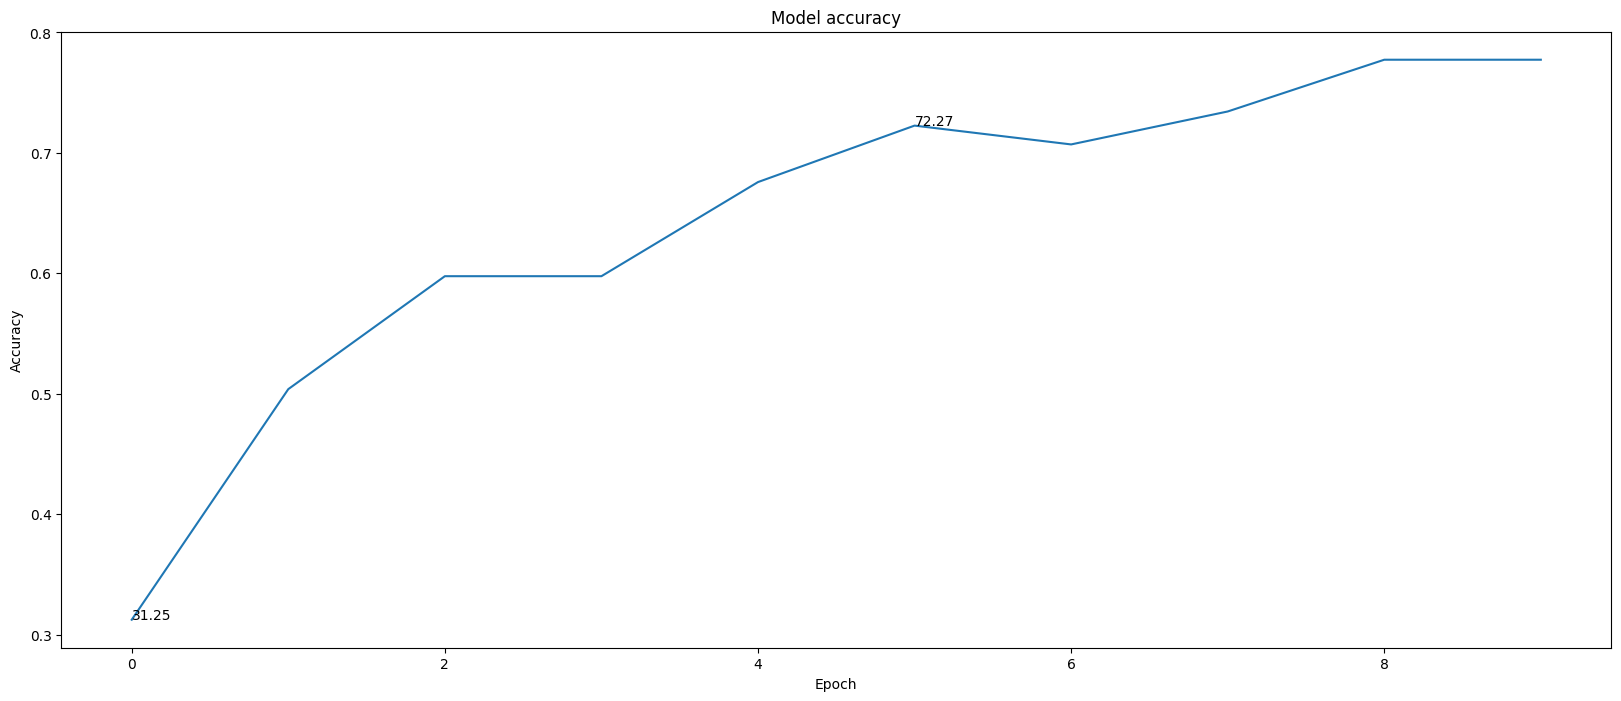

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

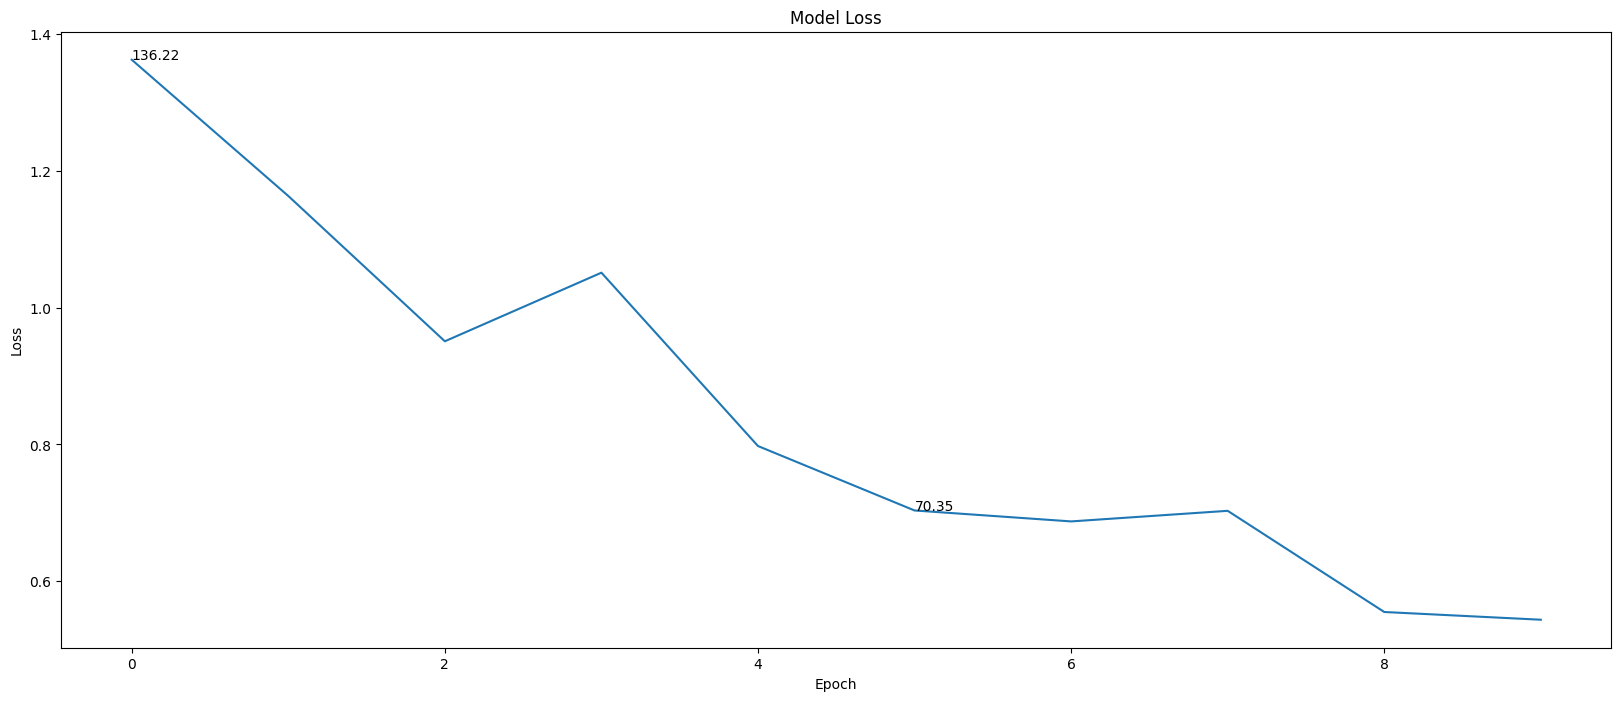

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()